In [2]:
import pickle
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [34]:
with open("../logs/7/search_result.pkl", "rb") as fp:
    search_result = pickle.load(fp)

cv_results = pd.DataFrame.from_dict(search_result.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__activation,param_classifier__batch_size,param_classifier__input_shape,param_classifier__optimizer,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.736468,0.058619,0.124065,0.028766,softmax,20,"1,300,23",adam,"{'classifier__activation': 'softmax', 'classif...",0.4375,...,0.4375,0.5,0.5,0.5,0.5,0.5,0.5,0.475,0.030619,1
1,0.585686,0.087552,0.080565,0.012082,softmax,10,"1,300,23",adam,"{'classifier__activation': 'softmax', 'classif...",0.4375,...,0.4375,0.5,0.5,0.5,0.5,0.5,0.5,0.475,0.030619,1


In [35]:
best_params = search_result.best_params_
print(best_params)
best_model_results = cv_results.where((cv_results["param_classifier__criterion"] == "entropy") & (
            cv_results["param_classifier__max_depth"] == 18) & (cv_results[
                                                                    "param_classifier__max_features"] == "sqrt")).dropna()
best_model_results

{'classifier__activation': 'softmax', 'classifier__batch_size': 20, 'classifier__input_shape': '1,300,23', 'classifier__optimizer': 'adam'}


KeyError: 'param_classifier__criterion'

In [5]:
best_model_results["params"] = best_model_results["params"].apply(lambda x: json.dumps(x))
best_model_results = best_model_results.drop_duplicates(subset=("params", "iter"))

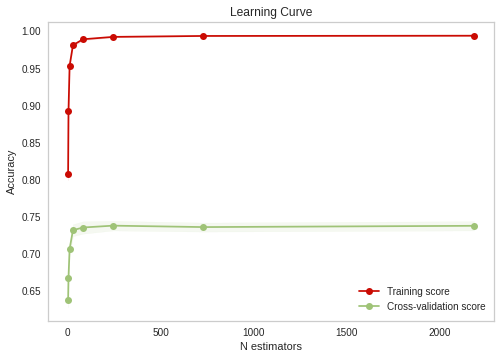

In [6]:
plt.figure()
plt.title("Learning Curve")
plt.xlabel("N estimators")
plt.ylabel("Accuracy")
train_sizes = best_model_results["param_classifier__n_estimators"].astype(int)
train_scores_mean = best_model_results["mean_train_score"]
train_scores_std = best_model_results["std_train_score"]
test_scores_mean = best_model_results["mean_test_score"]
test_scores_std = best_model_results["std_test_score"]
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

In [19]:
from yellowbrick.model_selection import LearningCurve, learning_curve
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score


In [12]:
best_estimator = search_result.estimator.set_params(**best_params)
n_splits = 2
seed = 123
test_size = .2
cv = StratifiedKFold(n_splits=n_splits, random_state=seed,
                     shuffle=True)
visualizer = LearningCurve(estimator=best_estimator, scoring="accuracy")

In [9]:
num_samples = 200
X = np.random.random(num_samples * 300 * 23).reshape((num_samples, 300, 23))
y = np.concatenate((np.zeros((num_samples // 2)), np.ones((num_samples // 2))))

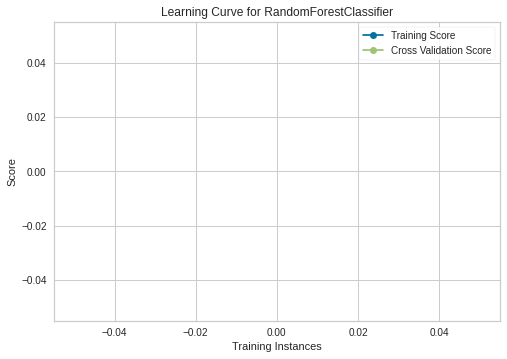

<AxesSubplot:title={'center':'Learning Curve for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [10]:
visualizer.fit(X,y)
visualizer.show()

plot accuracy while fitting more trees

In [22]:
warm_start_params = best_params.copy()
warm_start_params['classifier__n_estimators'] = 0
warm_start_params["classifier__warm_start"] = True


In [23]:
best_estimator = search_result.estimator.set_params(**warm_start_params)

num_samples = 200
X = np.random.random(num_samples * 300 * 23).reshape((num_samples, 300, 23))
y = np.concatenate((np.zeros((num_samples // 2)), np.ones((num_samples // 2))))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                        random_state=seed)

In [33]:
best_estimator.named_steps["scaler"]

MinMaxScaler()

In [31]:
test_errors =  []
train_erros = []
for added_estimators in range(0, 2200, 100):
    best_estimator.named_steps["classifier"].n_estimators+= added_estimators
    best_estimator.fit(X_train, y_train)
    y_hat_train = best_estimator.predict(X_train, y_train)
    y_hat_test = best_estimator.predict(X_test, y_test)
    test_errors.append(accuracy_score(y_train, y_hat_train))
    test_errors.append(accuracy_score(y_test, y_hat_test))


ValueError: Found array with dim 3. MinMaxScaler expected <= 2.

In [ ]:
_ = plt.plot(test_errors, '-r')
